In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# 모든 변수


=== Step 1: 데이터 전처리 시작 (SMOTE 포함) ===
데이터 로드 완료: Hotel Reservations_original.csv
데이터 크기: (36275, 18)
라벨 인코딩 완료: ['type_of_meal_plan', 'room_type_reserved', 'market_segment_type', 'booking_status']

=== 클래스 불균형 완화: SMOTE 적용 ===
SMOTE 이후 데이터 크기: (48780, 17), 클래스 분포: [24390 24390]

=== Step 3: 데이터 분할 시작 ===
학습 데이터 크기: (39024, 17)
테스트 데이터 크기: (9756, 17)

=== Step 4: 초기 모델 학습 및 평가 (Feature Scaling 포함) ===

--- Logistic Regression (Scaled) ---
Accuracy: 0.80
Confusion Matrix:
[[3938  940]
 [1047 3831]]

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80      4878
           1       0.80      0.79      0.79      4878

    accuracy                           0.80      9756
   macro avg       0.80      0.80      0.80      9756
weighted avg       0.80      0.80      0.80      9756


--- Decision Tree ---
Accuracy: 0.89
Confusion Matrix:
[[4377  501]
 [ 553 4325]]

Classification Report:
              precision    recall  f1-s

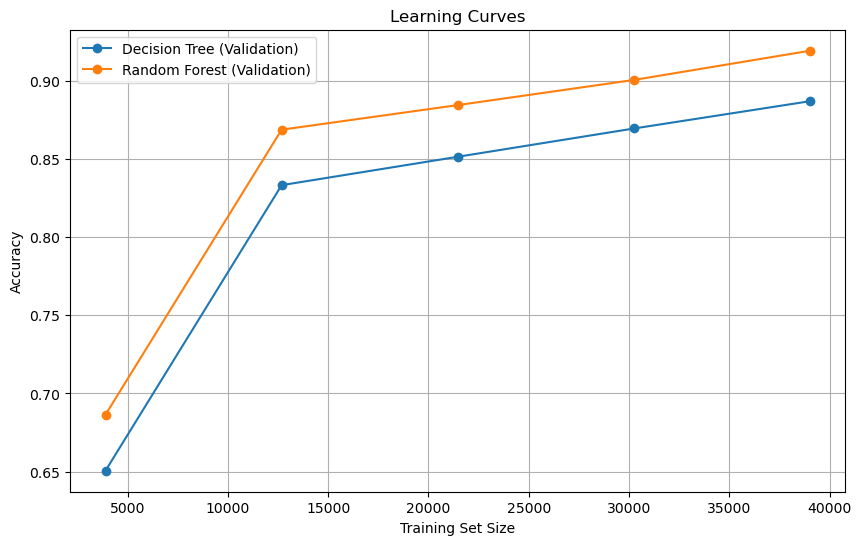


=== Step 7: 교차 검증 결과 ===
Decision Tree: Mean Accuracy = 0.89, Std Dev = 0.02
Random Forest: Mean Accuracy = 0.92, Std Dev = 0.02


In [11]:
#전체데이터
# === Step 1: 데이터 준비 및 전처리 (SMOTE 포함) ===
def preprocess_data_with_smote(file_path, target_column):
    print("\n=== Step 1: 데이터 전처리 시작 (SMOTE 포함) ===")
    dataset = pd.read_csv(file_path)
    print(f"데이터 로드 완료: {file_path}")
    print(f"데이터 크기: {dataset.shape}")
    encoders = {}
    for column in dataset.columns:
        if dataset[column].dtype == 'object':
            encoder = LabelEncoder()
            dataset[column] = encoder.fit_transform(dataset[column])
            encoders[column] = encoder
    print(f"라벨 인코딩 완료: {list(encoders.keys())}")
    X = dataset.drop(columns=[target_column])
    y = dataset[target_column]

    # SMOTE 적용
    print("\n=== 클래스 불균형 완화: SMOTE 적용 ===")
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    print(f"SMOTE 이후 데이터 크기: {X_resampled.shape}, 클래스 분포: {np.bincount(y_resampled)}")
    return X_resampled, y_resampled, encoders


# === Step 3: 학습 및 테스트 데이터 분할 ===
def split_data(X, y, test_size=0.2):
    print("\n=== Step 3: 데이터 분할 시작 ===")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)
    print(f"학습 데이터 크기: {X_train.shape}")
    print(f"테스트 데이터 크기: {X_test.shape}")
    return X_train, X_test, y_train, y_test

# === Step 4: 초기 모델 학습 및 평가 ===
def evaluate_initial_models_with_scaling(X_train, X_test, y_train, y_test):
    print("\n=== Step 4: 초기 모델 학습 및 평가 (Feature Scaling 포함) ===")
    models = {
        "Logistic Regression (Scaled)": Pipeline([
            ('scaler', StandardScaler()),
            ('lr', LogisticRegression(random_state=42, max_iter=500))
        ]),
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "Random Forest": RandomForestClassifier(random_state=42)
    }
    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"\n--- {name} ---")
        print(f"Accuracy: {accuracy:.2f}")
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred))
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        results[name] = accuracy
    return results

# === Step 5: 하이퍼파라미터 튜닝 ===
def tune_hyperparameters(X_train, y_train):
    print("\n=== Step 5: 하이퍼파라미터 튜닝 시작 ===")
    tuned_models = {}
    print("Decision Tree 하이퍼파라미터 탐색")
    dt_param_grid = {
        'max_depth': [3, 5, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_param_grid, cv=5, scoring='accuracy')
    dt_grid.fit(X_train, y_train)
    tuned_models['Decision Tree'] = dt_grid.best_estimator_
    print(f"Best Params for Decision Tree: {dt_grid.best_params_}")

    print("Random Forest 하이퍼파라미터 탐색")
    rf_param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
    rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, scoring='accuracy')
    rf_grid.fit(X_train, y_train)
    tuned_models['Random Forest'] = rf_grid.best_estimator_
    print(f"Best Params for Random Forest: {rf_grid.best_params_}")

    print("튜닝 완료. 최적 모델 반환.")
    return tuned_models

# === Step 6: 학습 곡선 출력 ===
def plot_learning_curves(models, model_names, X, y):
    print("\n=== Step 6: 학습 곡선 생성 중 ===")
    plt.figure(figsize=(10, 6))
    for model, name in zip(models, model_names):
        train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, scoring='accuracy')
        train_scores_mean = np.mean(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        plt.plot(train_sizes, test_scores_mean, 'o-', label=f"{name} (Validation)")
    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy")
    plt.title("Learning Curves")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# === Step 7: 교차 검증 결과 출력 ===
def evaluate_with_cross_validation(models, model_names, X, y):
    print("\n=== Step 7: 교차 검증 결과 ===")
    for model, name in zip(models, model_names):
        scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
        print(f"{name}: Mean Accuracy = {np.mean(scores):.2f}, Std Dev = {np.std(scores):.2f}")

# === Main Workflow ===
if __name__ == "__main__":
    # Step 1: 데이터 준비 및 전처리 (SMOTE 포함)
    file_path = 'Hotel Reservations_original.csv'  # 데이터 파일 경로
    target_column = 'booking_status'
    X_resampled, y_resampled, encoders = preprocess_data_with_smote(file_path, target_column)

    # Step 3: 학습 및 테스트 데이터 분할
    # X_resampled과 y_resampled을 사용해야 합니다.
    X_train, X_test, y_train, y_test = split_data(X_resampled, y_resampled)

    # Step 4: 초기 모델 학습 및 평가
    initial_results = evaluate_initial_models_with_scaling(X_train, X_test, y_train, y_test)

    # Step 5: 하이퍼파라미터 튜닝
    #tuned_models = tune_hyperparameters(X_train, y_train)

    # Step 6: 학습 곡선 출력
    plot_learning_curves(
        models=[DecisionTreeClassifier(random_state=42), RandomForestClassifier(random_state=42)], #list(tuned_models.values()),
        model_names=["Decision Tree", "Random Forest"], #list(tuned_models.keys()),
        X=X_resampled,  # 전체 데이터를 학습 곡선에 사용
        y=y_resampled
    )

    # Step 7: 교차 검증 결과 출력
    evaluate_with_cross_validation(
        models=[DecisionTreeClassifier(random_state=42), RandomForestClassifier(random_state=42)], #list(tuned_models.values()),
        model_names=["Decision Tree", "Random Forest"], #list(tuned_models.keys()),
        X=X_resampled,  # 전체 데이터를 교차 검증에 사용
        y=y_resampled
    )

In [57]:
# SMOTE(새로운 샘플을 생성하여 클래스 불균형 해소)로 인해 instance수 증가: 36275 -> 48780
print(X_resampled.shape, y_resampled.shape)

(48780, 17) (48780,)


### ANOVA 분석을 위한 표 만들기 (모든 변수)

**1-1. 전체 Training Set Size에 대한 표 (5개 ∵그래프 점이 5개)**  
- learning_curve_table_ALL.csv

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import learning_curve

# 학습 곡선을 표로 변환하는 함수
def create_learning_curve_table_from_plot(models, model_names, X, y, n_intervals=7):
    print("\n=== 학습 곡선 데이터 표 생성 중 ===")
    table_data = {}
    training_sizes = None

    # 각 모델에 대해 학습 곡선을 생성하고, 이를 표로 변환
    for model, name in zip(models, model_names):
        # learning_curve 함수로 학습 곡선 데이터 수집
        train_sizes, train_scores, test_scores = learning_curve(
            model, X, y, cv=5, scoring='accuracy', n_jobs=-1
        )
        
        # 학습 크기별로 평균 정확도를 계산
        test_scores_mean = np.mean(test_scores, axis=1)
        
        if training_sizes is None:  # 최초 루프에서 학습 크기 설정
            training_sizes = train_sizes
            table_data["Training Size"] = training_sizes

        table_data[name] = test_scores_mean

    # DataFrame 생성
    learning_curve_df = pd.DataFrame(table_data)
    return learning_curve_df

# 예시 모델 리스트와 이름
models=[DecisionTreeClassifier(random_state=42), RandomForestClassifier(random_state=42)] #list(tuned_models.values())  # 튜닝된 모델 리스트
model_names=["Decision Tree", "Random Forest"] #list(tuned_models.keys())  # 모델 이름 리스트

# 학습 곡선 데이터를 표로 변환
learning_curve_table = create_learning_curve_table_from_plot(
    models=models,
    model_names=model_names,
    X=X_resampled,  # 전체 데이터 (재샘플링된 X)
    y=y_resampled   # 라벨 (재샘플링된 y)
)

# CSV로 저장
output_csv = "learning_curve_table_ALL(tuneX).csv"
learning_curve_table.to_csv(output_csv, index=False)
print(f"학습 곡선 데이터 표 저장 완료: {output_csv}")


=== 학습 곡선 데이터 표 생성 중 ===
학습 곡선 데이터 표 저장 완료: learning_curve_table_ALL(tuneX).csv


# 10개 속성


=== Step 1: 데이터 전처리 시작 (SMOTE 포함) ===
데이터 로드 완료: Hotel Reservations_original.csv
데이터 크기: (36275, 11)
라벨 인코딩 완료: ['market_segment_type', 'booking_status']

=== 클래스 불균형 완화: SMOTE 적용 ===
SMOTE 이후 데이터 크기: (48780, 10)
SMOTE 이후 클래스 분포: [24390 24390]

=== Step 3: 데이터 분할 시작 ===
학습 데이터 크기: (39024, 10)
테스트 데이터 크기: (9756, 10)

=== Step 4: 초기 모델 학습 및 평가 (Feature Scaling 포함) ===

--- Logistic Regression (Scaled) ---
Accuracy: 0.80
Confusion Matrix:
[[3955  923]
 [1032 3846]]

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80      4878
           1       0.81      0.79      0.80      4878

    accuracy                           0.80      9756
   macro avg       0.80      0.80      0.80      9756
weighted avg       0.80      0.80      0.80      9756


--- Decision Tree ---
Accuracy: 0.90
Confusion Matrix:
[[4388  490]
 [ 525 4353]]

Classification Report:
              precision    recall  f1-score   support

           0       

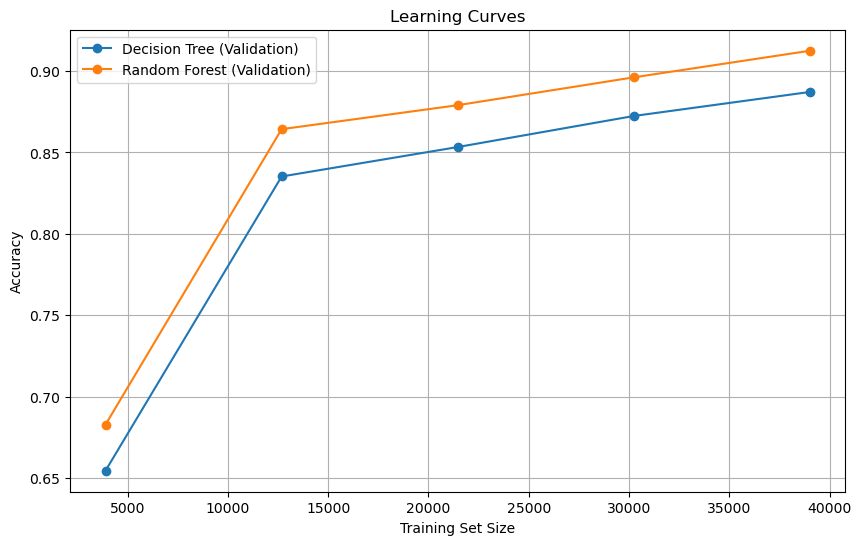


=== Step 7: 교차 검증 결과 ===
Decision Tree: Mean Accuracy = 0.89, Std Dev = 0.02
Random Forest: Mean Accuracy = 0.91, Std Dev = 0.02


In [17]:
#10개 속성,  'lead_time', 'avg_price_per_room', 'no_of_special_requests',
  #  'no_of_weekend_nights', 'no_of_week_nights', 'market_segment_type',
   # 'required_car_parking_space', 'repeated_guest', 'arrival_year', 'arrival_month' 넣고 돌린 결과

# === Step 1: 데이터 준비 및 전처리 (SMOTE 포함) ===
def preprocess_data_with_smote(file_path, target_column):
    print("\n=== Step 1: 데이터 전처리 시작 (SMOTE 포함) ===")
    dataset = pd.read_csv(file_path)
    
    # 사용할 속성 (열) 정의
    selected_columns = ['lead_time', 'avg_price_per_room', 'no_of_special_requests',
                        'no_of_weekend_nights', 'no_of_week_nights', 'market_segment_type',
                        'required_car_parking_space', 'repeated_guest', 'arrival_year', 'arrival_month']
    
    # 필요한 열만 선택
    dataset = dataset[selected_columns + [target_column]]
    
    print(f"데이터 로드 완료: {file_path}")
    print(f"데이터 크기: {dataset.shape}")

    # 문자열 열에 대해 라벨 인코딩 수행
    encoders = {}
    for column in dataset.columns:
        if dataset[column].dtype == 'object':
            encoder = LabelEncoder()
            dataset[column] = encoder.fit_transform(dataset[column])
            encoders[column] = encoder
    print(f"라벨 인코딩 완료: {list(encoders.keys())}")

    # X, y 데이터 분리
    X = dataset.drop(columns=[target_column])
    y = dataset[target_column]

    # SMOTE 적용
    print("\n=== 클래스 불균형 완화: SMOTE 적용 ===")
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    print(f"SMOTE 이후 데이터 크기: {X_resampled.shape}")
    print(f"SMOTE 이후 클래스 분포: {np.bincount(y_resampled)}")
    return X_resampled, y_resampled, encoders

# === Step 3: 학습 및 테스트 데이터 분할 ===
def split_data(X, y, test_size=0.2):
    print("\n=== Step 3: 데이터 분할 시작 ===")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)
    print(f"학습 데이터 크기: {X_train.shape}")
    print(f"테스트 데이터 크기: {X_test.shape}")
    return X_train, X_test, y_train, y_test

# === Step 4: 초기 모델 학습 및 평가 ===
def evaluate_initial_models_with_scaling(X_train, X_test, y_train, y_test):
    print("\n=== Step 4: 초기 모델 학습 및 평가 (Feature Scaling 포함) ===")
    models = {
        "Logistic Regression (Scaled)": Pipeline([
            ('scaler', StandardScaler()),
            ('lr', LogisticRegression(random_state=42, max_iter=500))
        ]),
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "Random Forest": RandomForestClassifier(random_state=42)
    }
    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"\n--- {name} ---")
        print(f"Accuracy: {accuracy:.2f}")
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred))
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        results[name] = accuracy
    return results

# === Step 5: 하이퍼파라미터 튜닝 ===
def tune_hyperparameters(X_train, y_train):
    print("\n=== Step 5: 하이퍼파라미터 튜닝 시작 ===")
    tuned_models = {}
    print("Decision Tree 하이퍼파라미터 탐색")
    dt_param_grid = {
        'max_depth': [3, 5, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_param_grid, cv=5, scoring='accuracy')
    dt_grid.fit(X_train, y_train)
    tuned_models['Decision Tree'] = dt_grid.best_estimator_
    print(f"Best Params for Decision Tree: {dt_grid.best_params_}")

    print("Random Forest 하이퍼파라미터 탐색")
    rf_param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
    rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, scoring='accuracy')
    rf_grid.fit(X_train, y_train)
    tuned_models['Random Forest'] = rf_grid.best_estimator_
    print(f"Best Params for Random Forest: {rf_grid.best_params_}")

    print("튜닝 완료. 최적 모델 반환.")
    return tuned_models

# === Step 6: 학습 곡선 출력 ===
def plot_learning_curves(models, model_names, X, y):
    print("\n=== Step 6: 학습 곡선 생성 중 ===")
    plt.figure(figsize=(10, 6))
    for model, name in zip(models, model_names):
        train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, scoring='accuracy')
        train_scores_mean = np.mean(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        plt.plot(train_sizes, test_scores_mean, 'o-', label=f"{name} (Validation)")
    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy")
    plt.title("Learning Curves")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# === Step 7: 교차 검증 결과 출력 ===
def evaluate_with_cross_validation(models, model_names, X, y):
    print("\n=== Step 7: 교차 검증 결과 ===")
    for model, name in zip(models, model_names):
        scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
        print(f"{name}: Mean Accuracy = {np.mean(scores):.2f}, Std Dev = {np.std(scores):.2f}")

# === Main Workflow ===
if __name__ == "__main__":
    # Step 1: 데이터 준비 및 전처리 (SMOTE 포함)
    file_path = 'Hotel Reservations_original.csv'  # 데이터 파일 경로
    target_column = 'booking_status'
    X_resampled, y_resampled, encoders = preprocess_data_with_smote(file_path, target_column)

    # Step 3: 학습 및 테스트 데이터 분할
    X_train, X_test, y_train, y_test = split_data(X_resampled, y_resampled)

    # Step 4: 초기 모델 학습 및 평가
    initial_results = evaluate_initial_models_with_scaling(X_train, X_test, y_train, y_test)

    # Step 5: 하이퍼파라미터 튜닝
    #tuned_models = tune_hyperparameters(X_train, y_train)

    # Step 6: 학습 곡선 출력
    plot_learning_curves(
        models=[DecisionTreeClassifier(random_state=42), RandomForestClassifier(random_state=42)], #list(tuned_models.values()),
        model_names=["Decision Tree", "Random Forest"], #list(tuned_models.keys()),
        X=X_resampled,  # 전체 데이터를 학습 곡선에 사용
        y=y_resampled
    )

    # Step 7: 교차 검증 결과 출력
    evaluate_with_cross_validation(
        models=[DecisionTreeClassifier(random_state=42), RandomForestClassifier(random_state=42)], #list(tuned_models.values()),
        model_names=["Decision Tree", "Random Forest"], #list(tuned_models.keys()),
        X=X_resampled,  # 전체 데이터를 교차 검증에 사용
        y=y_resampled
    )

### ANOVA 분석을 위한 표 만들기 (10개 변수)

**1. 위와 동일 (5개)**
- learning_curve_table_ALL_10variables.csv

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import learning_curve

# 학습 곡선을 표로 변환하는 함수
def create_learning_curve_table_from_plot(models, model_names, X, y, n_intervals=7):
    print("\n=== 학습 곡선 데이터 표 생성 중 ===")
    table_data = {}
    training_sizes = None

    # 각 모델에 대해 학습 곡선을 생성하고, 이를 표로 변환
    for model, name in zip(models, model_names):
        # learning_curve 함수로 학습 곡선 데이터 수집
        train_sizes, train_scores, test_scores = learning_curve(
            model, X, y, cv=5, scoring='accuracy', n_jobs=-1
        )
        
        # 학습 크기별로 평균 정확도를 계산
        test_scores_mean = np.mean(test_scores, axis=1)
        
        if training_sizes is None:  # 최초 루프에서 학습 크기 설정
            training_sizes = train_sizes
            table_data["Training Size"] = training_sizes

        table_data[name] = test_scores_mean

    # DataFrame 생성
    learning_curve_df = pd.DataFrame(table_data)
    return learning_curve_df

# 예시 모델 리스트와 이름
models=[DecisionTreeClassifier(random_state=42), RandomForestClassifier(random_state=42)] #list(tuned_models.values())  # 튜닝된 모델 리스트
model_names=["Decision Tree", "Random Forest"] #list(tuned_models.keys())  # 모델 이름 리스트

# 학습 곡선 데이터를 표로 변환
learning_curve_table = create_learning_curve_table_from_plot(
    models=models,
    model_names=model_names,
    X=X_resampled,  # 전체 데이터 (재샘플링된 X)
    y=y_resampled   # 라벨 (재샘플링된 y)
)

# CSV로 저장
output_csv = "learning_curve_table_ALL_10variables(tuneX).csv"
learning_curve_table.to_csv(output_csv, index=False)
print(f"학습 곡선 데이터 표 저장 완료: {output_csv}")


=== 학습 곡선 데이터 표 생성 중 ===
학습 곡선 데이터 표 저장 완료: learning_curve_table_ALL_10variables(tuneX).csv
